<a href="https://colab.research.google.com/github/studorache/MLC/blob/master/MLC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install --upgrade kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

#download data
!kaggle competitions download -c ml-challenge-week6

#unzip data
!unzip census-income.data.zip
!unzip census-income.test.zip

#create panda dataframe from training data
import pandas as pd 



Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes
census-income.names: Skipping, found more recently modified local copy (use --force to force download)
census-income.data.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
census-income.test.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  census-income.data.zip
replace census-income.data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: census-income.data      
Archive:  census-income.test.zip
replace census-income.test? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: census-income.test      


In [86]:
initial_train_df = pd.read_csv('census-income.data', header=None,sep=',')
final_test_df = pd.read_csv('census-income.test', header=None,sep=',')
initial_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [0]:
#get cols names
lines = open("census-income.names", "r").readlines()
i = 0
col_names = []
while i < len(lines):
    if i >= 81 and i<= 120:
      s = lines[i]
      col_names.append(s[s.find("(")+1:s.find(")")])
    i += 1
    
col_names.insert(col_names.index('detailed household summary in household')+1, 'instance weight') 

#Append cols list to test panda
final_test_df.columns = col_names


col_names.append('income class')
#Append cols list to train panda
initial_train_df.columns = col_names

In [88]:
train_df = initial_train_df.copy()
train_df

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.27,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,

In [0]:
categories_to_encode = ["class of worker", "education", "enroll in edu inst last wk", "marital stat", 
                       "major industry code", "major occupation code", "race", "hispanic origin", "sex", 
                       "member of a labor union", "reason for unemployment", "full or part time employment stat", 
                       "tax filer stat", "region of previous residence", "state of previous residence", 
                       "detailed household and family stat", "detailed household summary in household", 
                       "migration code-change in msa", "migration code-change in reg", 
                       "migration code-move within reg", "live in this house 1 year ago", 
                       "migration prev res in sunbelt", "family members under 18", "country of birth father", 
                       "country of birth mother", "country of birth self", "citizenship", 
                       "fill inc questionnaire for veteran's admin" ]

In [90]:
for cat in categories_to_encode:
  train_df[cat] = train_df[cat].astype('category')
  train_df[cat] = train_df[cat].cat.codes

train_df["income class"] = train_df["income class"].astype('category')
train_df["income class"] = train_df["income class"].cat.codes
train_df

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,3,0,0,12,0,2,6,14,6,4,0,0,1,3,2,0,0,0,4,3,36,24,6,1700.09,0,0,0,1,0,0,4,40,40,40,4,0,1,2,0,95,0
1,58,6,4,34,16,0,2,0,4,8,4,0,1,1,3,0,0,0,0,0,4,5,20,4,1053.55,3,8,9,0,3,1,4,40,40,40,4,0,1,2,52,94,0
2,18,3,0,0,0,0,1,4,14,6,1,0,0,1,3,2,0,0,0,4,3,36,2,0,991.95,0,0,0,1,0,0,4,41,41,41,0,0,1,2,0,95,0
3,9,3,0,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,8,2,1758.14,7,6,7,2,2,0,0,40,40,40,4,0,1,0,0,94,0
4,10,3,0,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,8,2,1069.16,7,6,7,2,2,0,0,40,40,40,4,0,1,0,0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,3,0,0,5,0,2,2,14,6,4,0,1,1,3,2,0,0,0,1,3,36,20,4,955.27,0,0,0,1,0,0,4,2,40,40,4,0,1,2,0,95,0
199519,65,5,37,2,1,0,2,2,2,2,4,0,1,1,3,0,6418,0,9,3,3,36,20,4,687.19,7,6,7,2,2,1,4,40,40,40,4,0,1,2,52,94,0
199520,47,3,0,0,16,0,2,2,14,6,4,0,1,1,3,0,0,0,157,2,3,36,20,4,1923.03,0,0,0,1,0,6,4,32,32,11,1,0,1,2,52,95,0
199521,16,3,0,0,0,0,1,4,14,6,4,0,0,1,3,2,0,0,0,4,3,36,8,2,4664.87,0,0,0,1,0,0,0,40,40,40,4,0,1,2,0,95,0


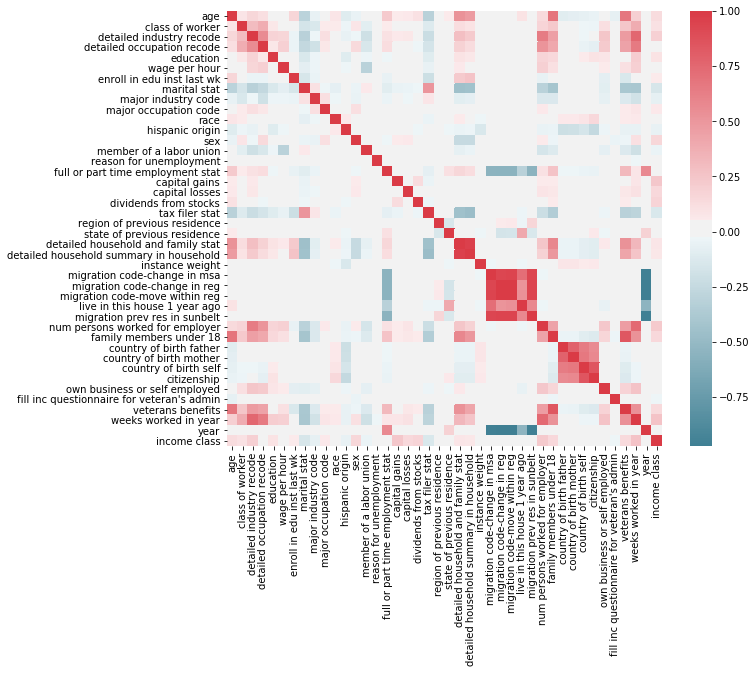

In [91]:
#find correlated
corr = train_df.corr()
import seaborn as sns
import matplotlib.pyplot as pl

f, ax = pl.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [92]:
cols_to_remove = ['year','country of birth mother', 'country of birth father', 'migration code-change in msa', 
                  'migration code-move within reg', 'live in this house 1 year ago','migration prev res in sunbelt',
                  'detailed household and family stat','country of birth self', 'detailed industry recode']
train_df=train_df.drop(columns=cols_to_remove, errors='ignore')
train_df

,age,class of worker,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household summary in household,instance weight,migration code-change in reg,num persons worked for employer,family members under 18,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,income class
0,73,3,0,12,0,2,6,14,6,4,0,0,1,3,2,0,0,0,4,3,36,6,1700.09,0,0,4,4,0,1,2,0,0
1,58,6,34,16,0,2,0,4,8,4,0,1,1,3,0,0,0,0,0,4,5,4,1053.55,8,1,4,4,0,1,2,52,0
2,18,3,0,0,0,1,4,14,6,1,0,0,1,3,2,0,0,0,4,3,36,0,991.95,0,0,4,0,0,1,2,0,0
3,9,3,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,2,1758.14,6,0,0,4,0,1,0,0,0
4,10,3,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,2,1069.16,6,0,0,4,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,3,0,5,0,2,2,14,6,4,0,1,1,3,2,0,0,0,1,3,36,4,955.27,0,0,4,4,0,1,2,0,0
199519,65,5,2,1,0,2,2,2,2,4,0,1,1,3,0,6418,0,9,3,3,36,4,687.19,6,1,4,4,0,1,2,52,0
199520,47,3,0,16,0,2,2,14,6,4,0,1,1,3,0,0,0,157,2,3,36,4,1923.03,0,6,4,1,0,1,2,52,0
199521,16,3,0,0,0,1,4,14,6,4,0,0,1,3,2,0,0,0,4,3,36,2,4664.87,0,0,0,4,0,1,2,0,0


Find important features

In [93]:
#split 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_df, train_df["income class"]):
    strat_train_set = train_df.loc[train_index]
    strat_test_set = train_df.loc[test_index]


X_train = strat_train_set.drop(columns=['instance weight','income class'])
y_train = strat_train_set['income class']
train_weights=strat_train_set['instance weight']
print(strat_train_set['income class'].value_counts() / len(strat_train_set))

X_test = strat_test_set.drop(columns=['instance weight','income class'])
y_test = strat_test_set['income class']
test_weights=strat_test_set['instance weight']
print(strat_test_set['income class'].value_counts() / len(strat_test_set))


0    0.937939
1    0.062061
Name: income class, dtype: float64
0    0.937953
1    0.062047
Name: income class, dtype: float64


In [94]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier() 
rf.fit(X_train, y_train,train_weights) 
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
age,0.129108
detailed occupation recode,0.108618
dividends from stocks,0.103626
capital gains,0.087163
education,0.066610
major industry code,0.062415
num persons worked for employer,0.051689
weeks worked in year,0.048277
sex,0.037965
major occupation code,0.035988


In [96]:
number_of_important_features = 15
important_features = feature_importances.iloc[0:number_of_important_features].index.values
important_features

array(['age', 'detailed occupation recode', 'dividends from stocks',
       'capital gains', 'education', 'major industry code',
       'num persons worked for employer', 'weeks worked in year', 'sex',
       'major occupation code', 'class of worker', 'capital losses',
       'detailed household summary in household',
       'full or part time employment stat', 'tax filer stat'],
      dtype=object)

In [97]:
train_df = initial_train_df[important_features].copy()
train_df

,age,detailed occupation recode,dividends from stocks,capital gains,education,major industry code,num persons worked for employer,weeks worked in year,sex,major occupation code,class of worker,capital losses,detailed household summary in household,full or part time employment stat,tax filer stat
0,73,0,0,0,High school graduate,Not in universe or children,0,0,Female,Not in universe,Not in universe,0,Other relative of householder,Not in labor force,Nonfiler
1,58,34,0,0,Some college but no degree,Construction,1,52,Male,Precision production craft & repair,Self-employed-not incorporated,0,Householder,Children or Armed Forces,Head of household
2,18,0,0,0,10th grade,Not in universe or children,0,0,Female,Not in universe,Not in universe,0,Child 18 or older,Not in labor force,Nonfiler
3,9,0,0,0,Children,Not in universe or children,0,0,Female,Not in universe,Not in universe,0,Child under 18 never married,Children or Armed Forces,Nonfiler
4,10,0,0,0,Children,Not in universe or children,0,0,Female,Not in universe,Not in universe,0,Child under 18 never married,Children or Armed Forces,Nonfiler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,7th and 8th grade,Not in universe or children,0,0,Male,Not in universe,Not in universe,0,Householder,Not in labor force,Joint both 65+
199519,65,2,9,6418,11th grade,Business and repair services,1,52,Male,Executive admin and managerial,Self-employed-incorporated,0,Householder,Children or Armed Forces,Joint one under 65 & one 65+
199520,47,0,157,0,Some college but no degree,Not in universe or children,6,52,Male,Not in universe,Not in universe,0,Householder,Children or Armed Forces,Joint both under 65
199521,16,0,0,0,10th grade,Not in universe or children,0,0,Female,Not in universe,Not in universe,0,Child under 18 never married,Not in labor force,Nonfiler


In [104]:
from sklearn.preprocessing import OneHotEncoder
col = train_df[important_features]

# binary encode
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(col)
print(enc.categories_)
pd.DataFrame(enc.transform(col).toarray()).head()

SyntaxError: ignored

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth': list(range(2,30,3)), 
              'max_features': ['None', 'sqrt', 'log2', "int", "float"], 
              'criterion': ['gini', 'entropy']}

clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators=100, random_state=42),
    param_distributions = param_grid, n_iter = 10,
    scoring='roc_auc', n_jobs=-1, cv = 3, refit=True, return_train_score = True)
clf.fit(X_train[important_features], y_train, train_weights )
clf.best_params_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'criterion': 'gini', 'max_depth': 17, 'max_features': 'log2'}

In [0]:
#Predict test data
y_pred=clf.predict(X_test[important_features])

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[37156,   273],
       [ 1538,   938]])

In [0]:
# Predict on competition data
y_pred=clf.predict(final_test_df[important_features])


result = pd.DataFrame(y_pred)
result.columns= ['income class']
result.to_csv('result.csv', index=True, index_label='index')
!kaggle competitions submit -c ml-challenge-week6 -f result.csv -m "First try."

100% 769k/769k [00:00<00:00, 2.49MB/s]
Successfully submitted to ML Challenge